<a href="https://colab.research.google.com/github/1998Jhonny/Data_Analist_Python/blob/main/Supermarket/Supermarket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Librerias

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

Importar los datos que están montados en el drive

In [2]:
aisles = pd.read_csv('/content/drive/MyDrive/Datos/Supermercado/aisles.csv', sep=';')
departments = pd.read_csv('/content/drive/MyDrive/Datos/Supermercado/departments.csv', sep=';')
order_products_prior = pd.read_csv('/content/drive/MyDrive/Datos/Supermercado/order_products__prior.csv', sep=';')
order_products_train = pd.read_csv('/content/drive/MyDrive/Datos/Supermercado/order_products__train.csv', sep=';')
orders = pd.read_csv('/content/drive/MyDrive/Datos/Supermercado/orders.csv', sep=';')
products = pd.read_csv('/content/drive/MyDrive/Datos/Supermercado/products.csv', sep=';')
sample_sumbission = pd.read_csv('/content/drive/MyDrive/Datos/Supermercado/sample_submission.csv', sep=';')

Validar algunas BD

In [3]:
print(aisles.info)
print(departments.info)
print(order_products_prior.info)
print(order_products_train.info)
print(orders.info)
print(products.info)
print(sample_sumbission.info)

<bound method DataFrame.info of      aisle_id                       aisle
0           1       prepared soups salads
1           2           specialty cheeses
2           3         energy granola bars
3           4               instant foods
4           5  marinades meat preparation
..        ...                         ...
129       130    hot cereal pancake mixes
130       131                   dry pasta
131       132                      beauty
132       133  muscles joints pain relief
133       134  specialty wines champagnes

[134 rows x 2 columns]>
<bound method DataFrame.info of     department_id       department
0               1           frozen
1               2            other
2               3           bakery
3               4          produce
4               5          alcohol
5               6    international
6               7        beverages
7               8             pets
8               9  dry goods pasta
9              10             bulk
10             11    p

Buscar los valores faltantes de la tabla products

Validación de datos Nulos

In [4]:
# Función para revisar nulos y % de nulos en cada columna
def resumen_nulos(df, nombre_df):
    resumen = df.isnull().sum().reset_index()
    resumen.columns = ["columna", "nulos"]
    resumen["%_nulos"] = (resumen["nulos"] / len(df)) * 100
    print(f"\n Resumen de nulos en {nombre_df} ({len(df)} registros):\n")
    print(resumen)

# Revisamos cada dataset
resumen_nulos(aisles, "aisle")
resumen_nulos(departments, "departments")
resumen_nulos(order_products_prior, "order_products__prior")
resumen_nulos(order_products_train, "order_products__train")
resumen_nulos(orders, "orders")
resumen_nulos(products, "products")
resumen_nulos(sample_sumbission, "sample_submission")


 Resumen de nulos en aisle (134 registros):

    columna  nulos  %_nulos
0  aisle_id      0      0.0
1     aisle      0      0.0

 Resumen de nulos en departments (21 registros):

         columna  nulos  %_nulos
0  department_id      0      0.0
1     department      0      0.0

 Resumen de nulos en order_products__prior (1048575 registros):

             columna  nulos  %_nulos
0           order_id      0      0.0
1         product_id      0      0.0
2  add_to_cart_order      0      0.0
3          reordered      0      0.0

 Resumen de nulos en order_products__train (1048575 registros):

             columna  nulos  %_nulos
0           order_id      0      0.0
1         product_id      0      0.0
2  add_to_cart_order      0      0.0
3          reordered      0      0.0

 Resumen de nulos en orders (1048575 registros):

                  columna  nulos   %_nulos
0                order_id      0  0.000000
1                 user_id      0  0.000000
2                eval_set      0  0.00

In [5]:
aisles.value_counts()

,,count
aisle_id,aisle,
1,prepared soups salads,1
2,specialty cheeses,1
3,energy granola bars,1
4,instant foods,1
5,marinades meat preparation,1
...,...,...
130,hot cereal pancake mixes,1
131,dry pasta,1
132,beauty,1


•	¿Con qué frecuencia compran los clientes? (promedio de días entre pedidos).

In [6]:
# Suponiendo que ya tienes cargado el DataFrame orders
# 1. Filtramos solo los pedidos que tienen valor en days_since_prior_order (excluimos el primer pedido)
orders_filtered = orders.dropna(subset=["days_since_prior_order"])

# 2. Promedio de días entre compras por cliente
freq_clientes = orders_filtered.groupby("user_id")["days_since_prior_order"].mean().reset_index()
freq_clientes.rename(columns={"days_since_prior_order": "promedio_dias_compra"}, inplace=True)

# 3. Promedio general del supermercado
freq_promedio_super = freq_clientes["promedio_dias_compra"].mean()

print(f"En promedio, los clientes compran cada {freq_promedio_super:.2f} días")


En promedio, los clientes compran cada 15.43 días


•	¿A qué horas y en qué días de la semana hay mayor volumen de pedidos?

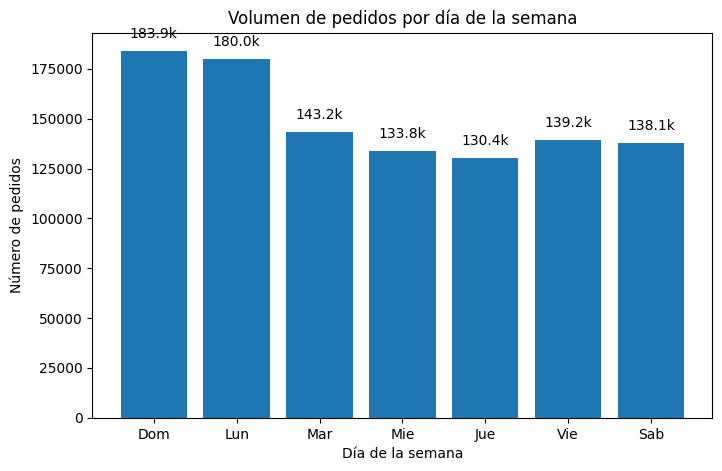

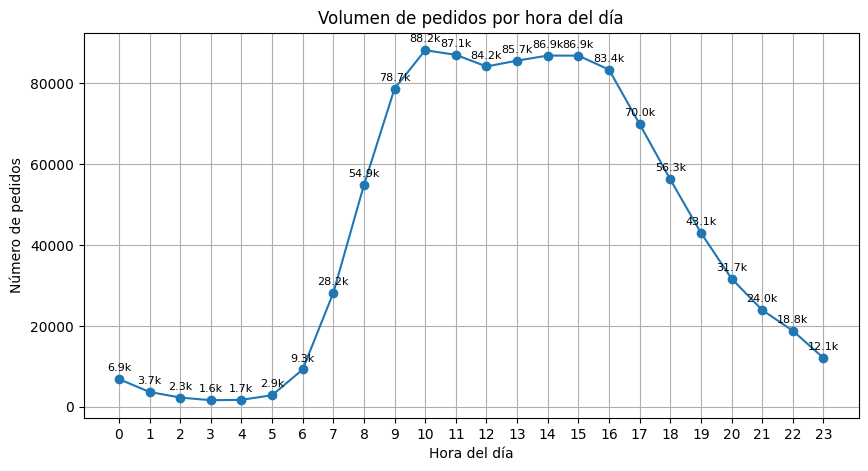

In [7]:
# -----------------------
# 1. Pedidos por día de la semana
# -----------------------
pedidos_por_dia = orders["order_dow"].value_counts().sort_index()

plt.figure(figsize=(8,5))
bars = plt.bar(pedidos_por_dia.index, pedidos_por_dia.values)
plt.xticks(range(7), ["Dom","Lun","Mar","Mie","Jue","Vie","Sab"])
plt.xlabel("Día de la semana")
plt.ylabel("Número de pedidos")
plt.title("Volumen de pedidos por día de la semana")

# Añadir etiquetas encima de cada barra en miles (k)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5000, f"{yval/1000:.1f}k",
             ha='center', va='bottom', fontsize=10)

plt.show()

# -----------------------
# 2. Pedidos por hora del día
# -----------------------
pedidos_por_hora = orders["order_hour_of_day"].value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.plot(pedidos_por_hora.index, pedidos_por_hora.values, marker="o")
plt.xticks(range(0,24))
plt.xlabel("Hora del día")
plt.ylabel("Número de pedidos")
plt.title("Volumen de pedidos por hora del día")

# Añadir etiquetas a cada punto en miles (k)
for x, y in zip(pedidos_por_hora.index, pedidos_por_hora.values):
    plt.text(x, y + 2000, f"{y/1000:.1f}k", ha='center', fontsize=8)

plt.grid(True)
plt.show()


Heatmap

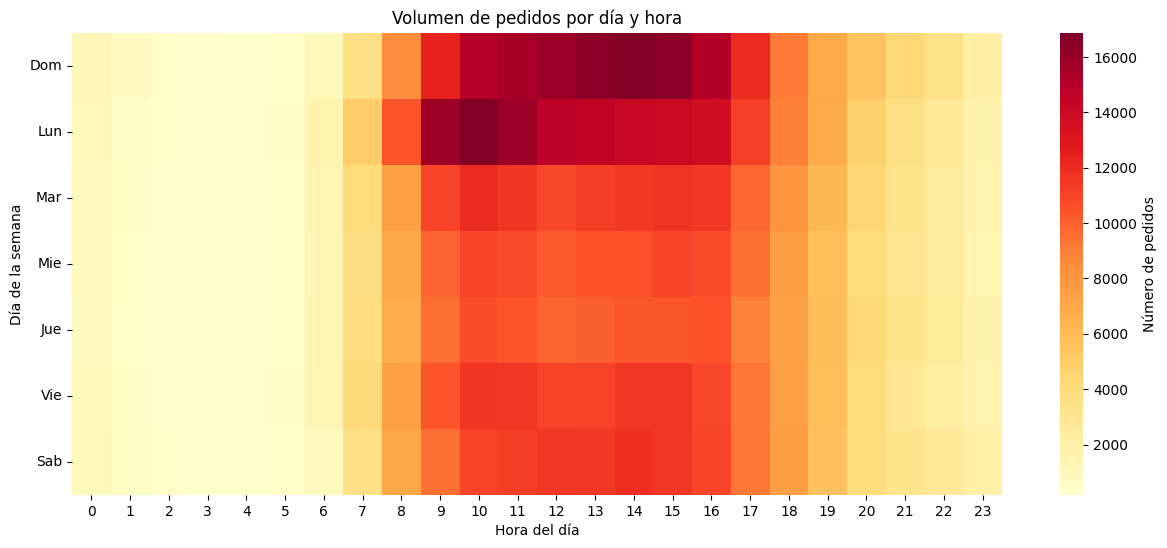

In [8]:
# -----------------------
# 1. Crear tabla dinámica (día vs hora)
# -----------------------
heatmap_data = orders.pivot_table(
    index="order_dow",
    columns="order_hour_of_day",
    values="order_id",
    aggfunc="count"
)

# -----------------------
# 2. Graficar heatmap
# -----------------------
plt.figure(figsize=(15,6))
sns.heatmap(heatmap_data, cmap="YlOrRd", cbar_kws={'label': 'Número de pedidos'})
plt.title("Volumen de pedidos por día y hora")
plt.xlabel("Hora del día")
plt.ylabel("Día de la semana")
plt.yticks(ticks=[0.5+i for i in range(7)], labels=["Dom","Lun","Mar","Mie","Jue","Vie","Sab"], rotation=0)
plt.show()


•	¿Cuál es la tasa de recompra por producto (reordered)? ¿Qué productos se convierten en compras recurrentes?

In [9]:
# Usaremos la tabla de compras previas
df = order_products_prior.merge(products, on="product_id", how="left")

# 1. Calcular tasa de recompra por producto
recompra = df.groupby(["product_id", "product_name"])["reordered"].agg(
    total_compras="count",
    total_reordenes="sum"
).reset_index()

recompra["tasa_recompra"] = recompra["total_reordenes"] / recompra["total_compras"]

# 2. Productos con mayor tasa de recompra (con mínimo 500 compras para que sea significativo)
top_recurrentes = recompra[recompra["total_compras"] > 500].sort_values("tasa_recompra", ascending=False).head(20)


top_recurrentes[["product_name", "tasa_recompra", "total_compras"]].head(10)

,product_name,tasa_recompra,total_compras
21028,"Milk, Organic, Vitamin D",0.862222,675
9982,Organic Unsweetened Vanilla Almond Milk,0.852686,577
27612,Organic Reduced Fat Milk,0.850394,1143
17745,Banana,0.842977,15450
9326,Bag of Organic Bananas,0.829801,12409
19884,Organic Whole Milk,0.828748,4362
25711,Organic Fat Free Milk,0.826286,875
14017,Spring Water,0.813168,1777
1034,Organic Milk,0.808756,868
23303,Organic Large Grade AA Brown Eggs,0.806650,812


In [10]:
# 3. Productos con menor tasa de recompra (también filtrando mínimo 500 compras)
low_recurrentes = recompra[recompra["total_compras"] > 500].sort_values("tasa_recompra", ascending=True).head(20)

low_recurrentes[["product_name", "tasa_recompra", "total_compras"]].head(10)


,product_name,tasa_recompra,total_compras
13146,Organic Ketchup,0.373308,517
8638,Basil Pesto,0.376200,521
28410,Organic Thyme,0.402208,634
5002,Organic Tomato Paste,0.426117,582
32473,Organic Low Sodium Chicken Broth,0.459410,542
22507,Extra Virgin Olive Oil,0.469820,1607
13574,Organic Butternut Squash,0.489922,645
28528,Organic Dill,0.491089,505
22536,Fresh Ginger Root,0.491204,739
11336,Shallot,0.495495,555


In [11]:
# 1. Unir prior con productos y departamentos
df = order_products_prior.merge(products, on="product_id", how="left")
df = df.merge(departments, on="department_id", how="left")

# 2. Contar ventas por producto dentro de cada departamento
ventas_por_prod = (
    df.groupby(["department", "product_id", "product_name"])["order_id"]
    .count()
    .reset_index(name="total_ventas")
)

# 3. Seleccionar el producto más vendido por departamento
mas_vendido_por_dep = ventas_por_prod.loc[
    ventas_por_prod.groupby("department")["total_ventas"].idxmax()
].sort_values("total_ventas", ascending=False)

print("Producto más vendido por departamento:")
display(mas_vendido_por_dep[["department", "product_name", "total_ventas"]])

Producto más vendido por departamento:


,department,product_name,total_ventas
30045,produce,Banana,15450
10089,dairy eggs,Organic Whole Milk,4362
5625,beverages,Sparkling Water Grapefruit,2433
12027,deli,Original Hummus,2298
1537,bakery,100% Whole Wheat Bread,1959
14415,frozen,Blueberries,1875
20143,meat seafood,Boneless Skinless Chicken Breasts,1618
23631,pantry,Extra Virgin Olive Oil,1607
7781,canned goods,Organic Black Beans,1245
17347,household,100% Recycled Paper Towels,840


¿Qué tan leales son los clientes? (usuarios con más de X pedidos, % de clientes que repiten)

In [12]:
# 1. Número de pedidos por cliente
pedidos_por_usuario = orders.groupby("user_id")["order_number"].max().reset_index()
pedidos_por_usuario.rename(columns={"order_number": "total_pedidos"}, inplace=True)

# 2. % de clientes que repiten
clientes_totales = len(pedidos_por_usuario)
clientes_recurrentes = len(pedidos_por_usuario[pedidos_por_usuario["total_pedidos"] > 1])
tasa_repeticion = (clientes_recurrentes / clientes_totales) * 100

print(f" Total de clientes: {clientes_totales}")
print(f" Clientes con más de 1 pedido: {clientes_recurrentes} ({tasa_repeticion:.2f}%)")

# 3. Clasificación por lealtad
pedidos_por_usuario["segmento"] = pd.cut(
    pedidos_por_usuario["total_pedidos"],
    bins=[0,2,10,100],
    labels=["Nuevos (1-2)", "Regulares (3-10)", "Leales (+10)"]
)

segmentos = pedidos_por_usuario["segmento"].value_counts(normalize=True) * 100
print("\n Distribución de clientes por lealtad (%):")
print(segmentos)


 Total de clientes: 63100
 Clientes con más de 1 pedido: 63100 (100.00%)

 Distribución de clientes por lealtad (%):
segmento
Regulares (3-10)    50.70206
Leales (+10)        49.29794
Nuevos (1-2)         0.00000
Name: proportion, dtype: float64


In [13]:
# Nueva clasificación con más granularidad
pedidos_por_usuario["segmento"] = pd.cut(
    pedidos_por_usuario["total_pedidos"],
    bins=[2,5,15,30,1000],
    labels=["Ocasionales (3-5)", "Frecuentes (6-15)", "Leales (16-30)", "Súper leales (+30)"]
)

segmentos_detalle = pedidos_por_usuario["segmento"].value_counts(normalize=True)
print("\n Nueva distribución de clientes por lealtad:")
display(segmentos_detalle)


 Nueva distribución de clientes por lealtad:


,proportion
segmento,
Frecuentes (6-15),0.448193
Ocasionales (3-5),0.211807
Leales (16-30),0.197036
Súper leales (+30),0.142964


In [14]:
# 1. Recency: tomamos el último pedido (máximo order_number)
recency = orders.groupby("user_id")["order_number"].max().reset_index()
recency.rename(columns={"order_number": "recency"}, inplace=True)

# 2. Frequency: cantidad total de pedidos
frequency = orders.groupby("user_id")["order_id"].count().reset_index()
frequency.rename(columns={"order_id": "frequency"}, inplace=True)

# 3. Monetary: total de productos comprados (join con order_products__prior)
monetary = order_products_prior.groupby("order_id")["product_id"].count().reset_index()
monetary = monetary.merge(orders[["order_id","user_id"]], on="order_id")
monetary = monetary.groupby("user_id")["product_id"].sum().reset_index()
monetary.rename(columns={"product_id": "monetary"}, inplace=True)

# 4. Unimos todo en un solo DataFrame
rfm = recency.merge(frequency, on="user_id").merge(monetary, on="user_id")

# 5. Normalizamos valores (para compararlos)
rfm_norm = rfm.copy()
rfm_norm[["recency","frequency","monetary"]] = rfm_norm[["recency","frequency","monetary"]].apply(lambda x: (x-x.min())/(x.max()-x.min()))

# 6. Score total (ponderación simple: recency 0.3, frequency 0.3, monetary 0.4)
rfm_norm["score"] = 0.3*(1-rfm_norm["recency"]) + 0.3*rfm_norm["frequency"] + 0.4*rfm_norm["monetary"]

# 7. Top clientes más atractivos
top_clientes = rfm_norm.sort_values("score", ascending=False).head(20)

print("Clientes más atractivos:")
display(top_clientes[["user_id","score"]])


Clientes más atractivos:


,user_id,score
2307,6710,0.700000
20304,60694,0.680952
1819,5360,0.623810
2205,6409,0.620346
4293,12666,0.616883
3106,9036,0.590909
786,2335,0.582251
10685,31763,0.568398
8044,23832,0.542424
13317,39648,0.530303


In [15]:
# 1. Tomamos los user_id del top clientes
top_ids = top_clientes["user_id"].tolist()

# 2. Extraemos sus valores originales de recency, frequency, monetary
top_detalle = rfm_norm[rfm_norm["user_id"].isin(top_ids)][
    ["user_id","recency","frequency","monetary","score"]
].sort_values("score", ascending=False)

print("Detalle de los clientes más atractivos:")
display(top_detalle.head(20))


Detalle de los clientes más atractivos:


,user_id,recency,frequency,monetary,score
2307,6710,1.000000,1.000000,1.000000,0.700000
20304,60694,0.708333,0.708333,0.952381,0.680952
1819,5360,0.552083,0.552083,0.809524,0.623810
2205,6409,0.395833,0.395833,0.800866,0.620346
4293,12666,0.312500,0.312500,0.792208,0.616883
3106,9036,1.000000,1.000000,0.727273,0.590909
786,2335,0.427083,0.427083,0.705628,0.582251
10685,31763,0.500000,0.500000,0.670996,0.568398
8044,23832,0.916667,0.916667,0.606061,0.542424
13317,39648,0.437500,0.437500,0.575758,0.530303


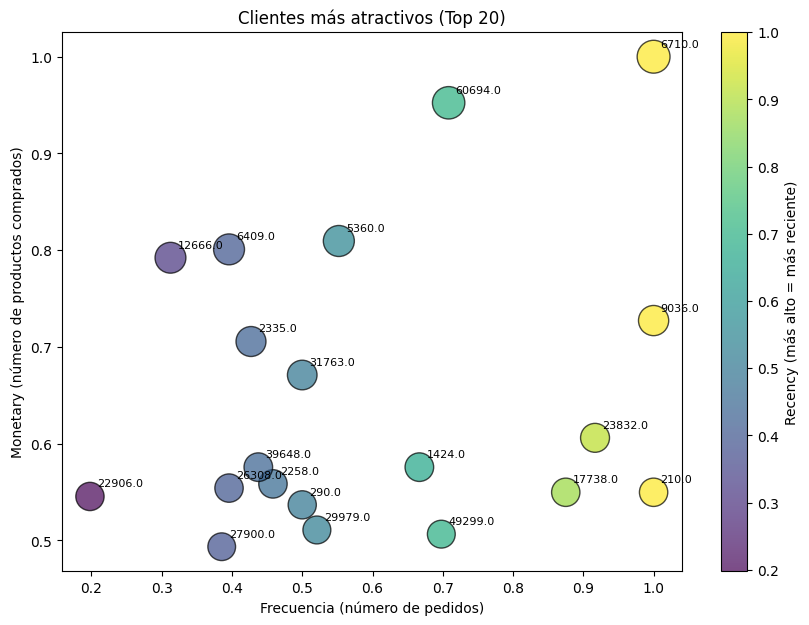

In [16]:
# Asegúrate de tener creado rfm_norm con user_id, recency, frequency, monetary y score
# Lista de los top clientes que compartiste
top_clientes_ids = [6710,60694,5360,6409,12666,9036,2335,31763,23832,39648,
                    1424,2258,26308,17738,210,22906,290,29979,49299,27900]

# Filtrar el top 20
top_detalle = rfm_norm[rfm_norm["user_id"].isin(top_clientes_ids)]

# Crear scatter plot
plt.figure(figsize=(10,7))
scatter = plt.scatter(
    top_detalle["frequency"],        # eje X: frecuencia de compras
    top_detalle["monetary"],         # eje Y: volumen de productos
    c=top_detalle["recency"],        # color: recencia (más claro = más reciente)
    s=top_detalle["score"]*800,      # tamaño proporcional al score
    cmap="viridis",
    alpha=0.7,
    edgecolors="k"
)

# Barra de color
plt.colorbar(scatter, label="Recency (más alto = más reciente)")
plt.xlabel("Frecuencia (número de pedidos)")
plt.ylabel("Monetary (número de productos comprados)")
plt.title("Clientes más atractivos (Top 20)")

# Etiquetar cada punto con su user_id
for _, row in top_detalle.iterrows():
    plt.text(row["frequency"]+0.01, row["monetary"]+0.01, str(row["user_id"]), fontsize=8)

plt.show()



¿Cuál es el ciclo de vida de un cliente (número promedio de pedidos antes de abandonar)?




In [17]:
# 1. Número de pedidos por cliente
pedidos_por_usuario = orders.groupby("user_id")["order_number"].max().reset_index()
pedidos_por_usuario.rename(columns={"order_number":"total_pedidos"}, inplace=True)

# 2. Ciclo de vida en pedidos (promedio)
promedio_pedidos = pedidos_por_usuario["total_pedidos"].mean()
print(f"Número promedio de pedidos antes de abandonar: {promedio_pedidos:.2f}")

# 3. Ciclo de vida en tiempo (suma de días activos por usuario)
tiempo_por_usuario = orders.groupby("user_id")["days_since_prior_order"].sum().reset_index()
tiempo_por_usuario.rename(columns={"days_since_prior_order":"total_dias"}, inplace=True)

promedio_dias = tiempo_por_usuario["total_dias"].mean()
print(f"Tiempo promedio activo de un cliente: {promedio_dias:.0f} días")

Número promedio de pedidos antes de abandonar: 16.62
Tiempo promedio activo de un cliente: 173 días


¿Cuáles son los productos más comprados en general?

In [18]:
# 1. Unir productos con compras
productos_vendidos = order_products_prior.merge(products, on="product_id", how="left")

# 2. Contar frecuencia de cada producto
top_productos = (
    productos_vendidos.groupby(["product_id", "product_name"])["order_id"]
    .count()
    .reset_index(name="total_compras")
    .sort_values("total_compras", ascending=False)
)

# 3. Mostrar Top 10 productos
print("Top 10 productos más comprados en general:")
display(top_productos.head(10))

Top 10 productos más comprados en general:


,product_id,product_name,total_compras
17745,24852,Banana,15450
9326,13176,Bag of Organic Bananas,12409
15053,21137,Organic Strawberries,8528
15614,21903,Organic Baby Spinach,7852
33682,47209,Organic Hass Avocado,6857
34079,47766,Organic Avocado,5646
33979,47626,Large Lemon,4928
11952,16797,Strawberries,4587
18712,26209,Limes,4526
19972,27966,Organic Raspberries,4420


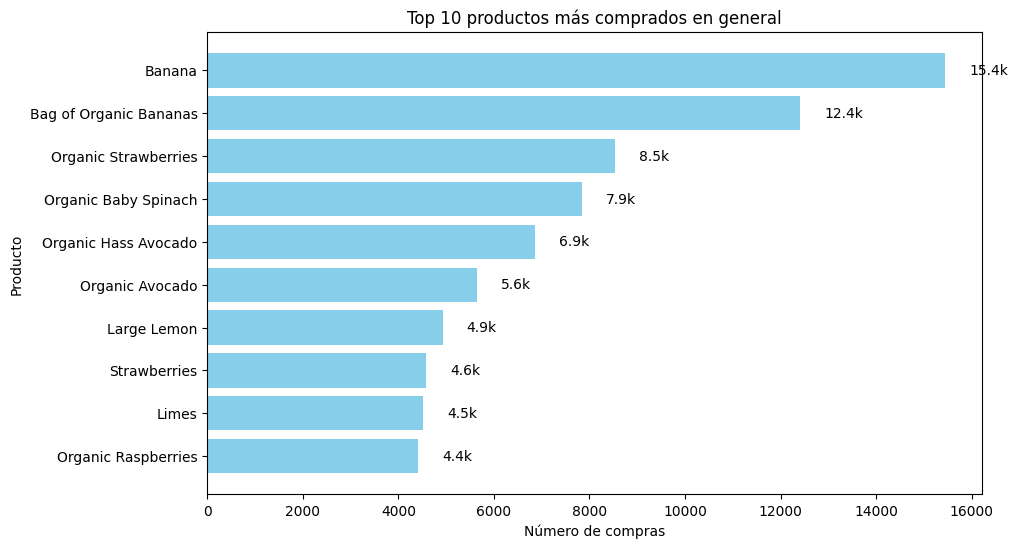

In [19]:
# Top 10 productos más comprados (ya calculados en top_productos)
top10 = top_productos.head(10)

# Crear gráfico de barras horizontal
plt.figure(figsize=(10,6))
plt.barh(top10["product_name"], top10["total_compras"], color="skyblue")
plt.xlabel("Número de compras")
plt.ylabel("Producto")
plt.title("Top 10 productos más comprados en general")

# Invertir el orden para que el más vendido quede arriba
plt.gca().invert_yaxis()

# Agregar valores en cada barra (en miles para mejor lectura)
for i, v in enumerate(top10["total_compras"]):
    plt.text(v + 500, i, f"{v/1000:.1f}k", va='center')

plt.show()

¿Qué pasillos y departamentos concentran la mayor parte de las ventas?

In [20]:
# Unir con products, aisles y departments
ventas = order_products_prior.merge(products, on="product_id", how="left") \
                             .merge(aisles, on="aisle_id", how="left") \
                             .merge(departments, on="department_id", how="left")

# Total de ventas por departamento
ventas_departamento = (
    ventas.groupby("department")["order_id"]
    .count()
    .reset_index(name="total_compras")
    .sort_values("total_compras", ascending=False)
)

ventas_departamento["porcentaje"] = (
    ventas_departamento["total_compras"] / ventas_departamento["total_compras"].sum()
)

# Total de ventas por pasillo
ventas_pasillo = (
    ventas.groupby("aisle")["order_id"]
    .count()
    .reset_index(name="total_compras")
    .sort_values("total_compras", ascending=False)
)

ventas_pasillo["porcentaje"] = (
    ventas_pasillo["total_compras"] / ventas_pasillo["total_compras"].sum()
)

# Mostrar top 10 departamentos y pasillos
print("Top 10 departamentos por ventas:")
display(ventas_departamento.head(10))

print("\nTop 10 pasillos por ventas:")
display(ventas_pasillo.head(10))


Top 10 departamentos por ventas:


,department,total_compras,porcentaje
19,produce,306252,0.292074
7,dairy eggs,175199,0.167088
20,snacks,93697,0.089359
3,beverages,87114,0.083081
10,frozen,72198,0.068856
16,pantry,60164,0.057379
2,bakery,38175,0.036408
6,canned goods,34456,0.032861
8,deli,34100,0.032521
9,dry goods pasta,27657,0.026377



Top 10 pasillos por ventas:


,aisle,total_compras,porcentaje
50,fresh fruits,117779,0.112327
53,fresh vegetables,110178,0.105077
98,packaged vegetables fruits,57352,0.054697
133,yogurt,46929,0.044756
93,packaged cheese,31648,0.030183
83,milk,28793,0.027460
131,water seltzer sparkling water,27029,0.025778
25,chips pretzels,23255,0.022178
119,soy lactosefree,20736,0.019776
11,bread,18980,0.018101


¿Qué productos se agregan primero al carrito (alta prioridad para el cliente)?

In [21]:
# Calcular la posición promedio de cada producto en el carrito
prioridad_productos = (
    order_products_prior.groupby("product_id")["add_to_cart_order"]
    .mean()
    .reset_index(name="posicion_promedio")
)

# Unir con el nombre de producto
prioridad_productos = prioridad_productos.merge(products, on="product_id", how="left")

# Ordenar por menor posición promedio (más prioridad)
top_prioritarios = prioridad_productos.sort_values("posicion_promedio").head(10)

print("Top 10 productos que los clientes agregan primero al carrito:")
display(top_prioritarios[["product_id","product_name","posicion_promedio"]])


Top 10 productos que los clientes agregan primero al carrito:


,product_id,product_name,posicion_promedio
6625,9311,Italian Salad Romaine & Radicchio,1.0
30102,42182,"Rice Drink, Enriched, Chocolate",1.0
30105,42185,Extra Strenght Antigas Chewable Cherry Crème,1.0
13409,18823,Sweet & Sour Red Cabbage,1.0
13410,18825,Wakame Seaweed & Shiitake Mushrooms,1.0
24528,34337,Vitex Fruit Capsules,1.0
28951,40577,Organic Magnolia and Poppy Scented Glass Cleaner,1.0
33830,47423,Roasted Jalapeno Hummus,1.0
24483,34277,Fresh Scent Disinfecting Wipes To Go,1.0
6571,9233,Saltines,1.0


In [22]:
# 1. Calcular promedio de posición
prioridad_productos = (
    order_products_prior.groupby("product_id")["add_to_cart_order"]
    .mean()
    .reset_index(name="posicion_promedio")
)

# 2. Contar cuántas veces un producto fue el primero en el carrito
primeros = order_products_prior[order_products_prior["add_to_cart_order"] == 1]
conteo_primeros = (
    primeros.groupby("product_id")["order_id"]
    .count()
    .reset_index(name="veces_primero")
)

# 3. Calcular el porcentaje sobre el total de pedidos
total_pedidos = orders["order_id"].nunique()
conteo_primeros["porcentaje_primero"] = (
    conteo_primeros["veces_primero"] / total_pedidos * 100
)

# 4. Unir con productos y con posición promedio
prioridad_productos = (
    prioridad_productos.merge(conteo_primeros, on="product_id", how="left")
    .merge(products, on="product_id", how="left")
)

# Reemplazar NaN (productos que nunca fueron primeros) con 0
prioridad_productos.fillna({"veces_primero": 0, "porcentaje_primero": 0}, inplace=True)

# 5. Ordenar por frecuencia de aparecer primero
top_prioritarios = prioridad_productos.sort_values("veces_primero", ascending=False).head(10)

print("Top 10 productos agregados primero al carrito:")
display(top_prioritarios[["product_id","product_name","posicion_promedio","veces_primero","porcentaje_primero"]])


Top 10 productos agregados primero al carrito:


,product_id,product_name,posicion_promedio,veces_primero,porcentaje_primero
17745,24852,Banana,4.895793,3570.0,0.340462
9326,13176,Bag of Organic Bananas,5.114433,2598.0,0.247765
19884,27845,Organic Whole Milk,5.372077,994.0,0.094795
15053,21137,Organic Strawberries,7.173194,879.0,0.083828
15614,21903,Organic Baby Spinach,7.389455,797.0,0.076008
33682,47209,Organic Hass Avocado,6.815663,755.0,0.072002
34079,47766,Organic Avocado,6.332625,712.0,0.067902
11952,16797,Strawberries,7.163942,525.0,0.050068
14017,19660,Spring Water,4.484524,510.0,0.048637
19972,27966,Organic Raspberries,7.231900,462.0,0.044060


¿Qué productos casi nunca se recompran (posible sobrestock o baja rotación)?

In [23]:
# 1. Calcular tasa de recompra por producto
tasa_recompra = (
    order_products_prior.groupby("product_id")["reordered"]
    .agg(["mean","count"])
    .reset_index()
    .rename(columns={"mean":"tasa_recompra","count":"total_compras"})
)

# 2. Unir con nombres de productos
tasa_recompra = tasa_recompra.merge(products, on="product_id", how="left")

# 3. Filtrar productos con al menos cierto número de compras (ej: >50) para evitar sesgo
tasa_recompra_filtrado = tasa_recompra[tasa_recompra["total_compras"] > 50]

# 4. Ordenar por menor tasa de recompra
productos_baja_rotacion = tasa_recompra_filtrado.sort_values("tasa_recompra").head(10)

print("Top 10 productos con menor tasa de recompra (baja rotación):")
display(productos_baja_rotacion[["product_id","product_name","total_compras","tasa_recompra"]])

Top 10 productos con menor tasa de recompra (baja rotación):


,product_id,product_name,total_compras,tasa_recompra
3993,5605,Sesame Seed,59,0.033898
34253,48017,Organic Hoisin Sauce,63,0.047619
8580,12113,Corn Starch,60,0.050000
5826,8203,Ground Ginger,54,0.055556
22338,31275,Organic High Fiber Coconut Flour,53,0.056604
8677,12260,Ground Cinnamon,67,0.059701
24208,33884,Bay Leaves,99,0.060606
26438,37033,Non-Stick Parchment Paper,60,0.066667
25681,35973,Paprika,89,0.067416
1691,2380,Cayenne Pepper,63,0.079365


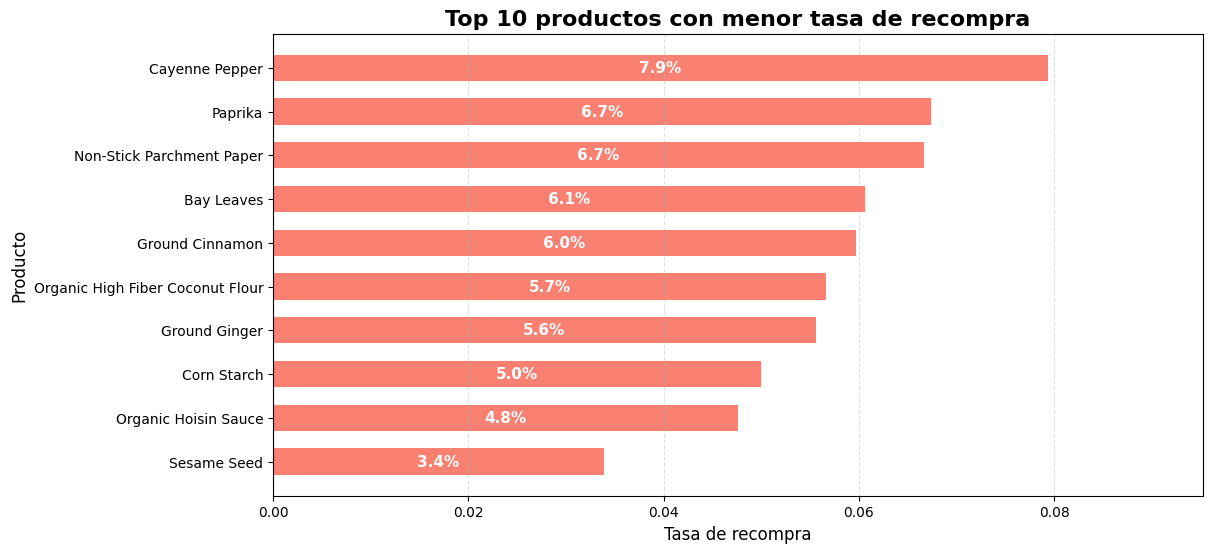

In [24]:
# Usar el dataframe productos_baja_rotacion ya calculado
top_baja_rotacion = productos_baja_rotacion.sort_values("tasa_recompra", ascending=True)

# Gráfico de barras horizontal
plt.figure(figsize=(12,6))
bars = plt.barh(
    top_baja_rotacion["product_name"],
    top_baja_rotacion["tasa_recompra"],
    color="salmon", height=0.6
)

# Título y etiquetas
plt.title("Top 10 productos con menor tasa de recompra", fontsize=16, weight="bold")
plt.xlabel("Tasa de recompra", fontsize=12)
plt.ylabel("Producto", fontsize=12)

# Añadir valores dentro de cada barra
for bar in bars:
    width = bar.get_width()
    plt.text(
        width/2,                                    # mitad de la barra
        bar.get_y() + bar.get_height()/2,           # centrado vertical
        f"{width*100:.1f}%",                        # convertir a porcentaje
        va="center", ha="center", color="white", fontsize=11, weight="bold"
    )

plt.xlim(0, max(top_baja_rotacion["tasa_recompra"])*1.2)
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.show()

¿Existen productos que impulsan la compra de otros (canasta básica + adicionales)?

In [25]:
# 1. Preparar las canastas: lista de listas de productos por order_id
canastas = (
    order_products_prior.merge(products, on="product_id", how="left")
    .groupby("order_id")["product_name"]
    .apply(list)
    .tolist()
)

# 2. Codificación para Apriori
te = TransactionEncoder()
canastas_encoded = te.fit(canastas).transform(canastas)
df_canastas = pd.DataFrame(canastas_encoded, columns=te.columns_)

# 3. Encontrar conjuntos frecuentes de productos
frequent_itemsets = apriori(df_canastas, min_support=0.01, use_colnames=True)  # 1% soporte mínimo

# 4. Generar reglas de asociación
reglas = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

# 5. Ordenar por confianza y lift
reglas = reglas.sort_values(["confidence","lift"], ascending=False)

# Mostrar top 15 reglas
display(reglas[["antecedents","consequents","support","confidence","lift"]].head(15))

,antecedents,consequents,support,confidence,lift
14,(Organic Fuji Apple),(Banana),0.010448,0.376646,2.536375
11,(Organic Avocado),(Banana),0.016522,0.304463,2.050290
4,(Organic Raspberries),(Bag of Organic Bananas),0.012716,0.299321,2.509629
19,(Strawberries),(Banana),0.012841,0.291258,1.961363
2,(Organic Hass Avocado),(Bag of Organic Bananas),0.019098,0.289777,2.429605
9,(Large Lemon),(Banana),0.012860,0.271510,1.828376
27,(Organic Raspberries),(Organic Strawberries),0.010044,0.236425,2.884400
6,(Organic Strawberries),(Bag of Organic Bananas),0.018915,0.230769,1.934861
16,(Organic Strawberries),(Banana),0.017916,0.218574,1.471902
12,(Organic Baby Spinach),(Banana),0.016349,0.216633,1.458828


In [26]:
# 1. Contar cuántas veces cada producto aparece como CONSEQUENT
consequents_counts = (
    reglas.explode("consequents")   # separar sets en filas
          .groupby("consequents")
          .agg(
              veces=("consequents","count"),
              support_promedio=("support","mean"),
              confianza_promedio=("confidence","mean"),
              lift_promedio=("lift","mean")
          )
          .reset_index()
          .sort_values("veces", ascending=False)
)

# 2. Ordenar por cuántas veces aparece como consequent
top_consequents = consequents_counts.head(15)

print("Productos ancla (más aparecen como consequents):")
display(top_consequents)


Productos ancla (más aparecen como consequents):


,consequents,veces,support_promedio,confianza_promedio,lift_promedio
1,Banana,6,0.014489,0.279847,1.884522
8,Organic Strawberries,5,0.014210,0.171921,2.097442
0,Bag of Organic Bananas,4,0.016683,0.257979,2.162997
4,Organic Baby Spinach,4,0.013699,0.137371,1.820213
6,Organic Hass Avocado,3,0.013985,0.150022,2.276303
7,Organic Raspberries,2,0.011380,0.114577,2.697014
5,Organic Fuji Apple,1,0.010448,0.070356,2.536375
3,Organic Avocado,1,0.016522,0.111262,2.050290
2,Large Lemon,1,0.012860,0.086602,1.828376
9,Strawberries,1,0.012841,0.086472,1.961363


App de score ancla

In [27]:
def obtener_metricas_bidireccional(producto_A, producto_B, reglas):
    """
    Devuelve soporte, confianza y lift de la relación entre producto_A y producto_B,
    en ambas direcciones (A→B y B→A).
    Si no existe la regla, devuelve 0 en los indicadores.
    """
    A = frozenset([producto_A])
    B = frozenset([producto_B])

    # Buscar regla A → B
    regla_AB = reglas[(reglas["antecedents"] == A) & (reglas["consequents"] == B)]

    # Buscar regla B → A
    regla_BA = reglas[(reglas["antecedents"] == B) & (reglas["consequents"] == A)]

    resultados = []

    if not regla_AB.empty:
        resultados.append(["A→B", producto_A, producto_B] + regla_AB[["support","confidence","lift"]].values[0].tolist())
    else:
        resultados.append(["A→B", producto_A, producto_B, 0, 0, 0])

    if not regla_BA.empty:
        resultados.append(["B→A", producto_B, producto_A] + regla_BA[["support","confidence","lift"]].values[0].tolist())
    else:
        resultados.append(["B→A", producto_B, producto_A, 0, 0, 0])

    return pd.DataFrame(resultados, columns=["Dirección","Antecedente","Consecuente","Support","Confidence","Lift"])

producto1 = input("Digite el nombre del primer producto: ")
producto2 = input("Digite el nombre del segundo producto: ")

resultado = obtener_metricas_bidireccional(producto1, producto2, reglas)
print("\n Resultados:")
display(resultado)


Digite el nombre del primer producto: Banana
Digite el nombre del segundo producto: Organic Strawberries

 Resultados:


,Dirección,Antecedente,Consecuente,Support,Confidence,Lift
0,A→B,Banana,Organic Strawberries,0.017916,0.120647,1.471902
1,B→A,Organic Strawberries,Banana,0.017916,0.218574,1.471902


¿Cuál es el tamaño promedio del carrito de compra? (productos por pedido)

In [29]:
# 1. Contar productos por pedido
productos_por_pedido = (
    order_products_prior.groupby("order_id")["product_id"]
    .count()
    .reset_index(name="num_productos")
)

# 2. Calcular promedio
promedio_carrito = productos_por_pedido["num_productos"].mean()

print(f"Tamaño promedio del carrito: {promedio_carrito:.2f} productos")


Tamaño promedio del carrito: 10.08 productos


¿Cuántos productos en promedio se repiten de pedidos anteriores en un nuevo pedido?

In [31]:
# 1. Trabajamos con el set de entrenamiento
df_train = order_products_train.copy()

# 2. Calcular productos repetidos vs total en cada pedido
recompra_por_pedido = (
    df_train.groupby("order_id")
    .agg(total_productos=("product_id","count"),
         repetidos=("reordered","sum"))
    .reset_index()
)

# 3. Calcular porcentaje de repetidos en cada pedido
recompra_por_pedido["pct_repetidos"] = recompra_por_pedido["repetidos"] / recompra_por_pedido["total_productos"]

# 4. Promedio global
promedio_repetidos = recompra_por_pedido["pct_repetidos"].mean()

print(f"En promedio, el {promedio_repetidos:.2%} de los productos en un pedido son recompra de compras anteriores.")


En promedio, el 60.28% de los productos en un pedido son recompra de compras anteriores.


¿Existen diferencias en el tipo de compra según el día de la semana u hora del día?

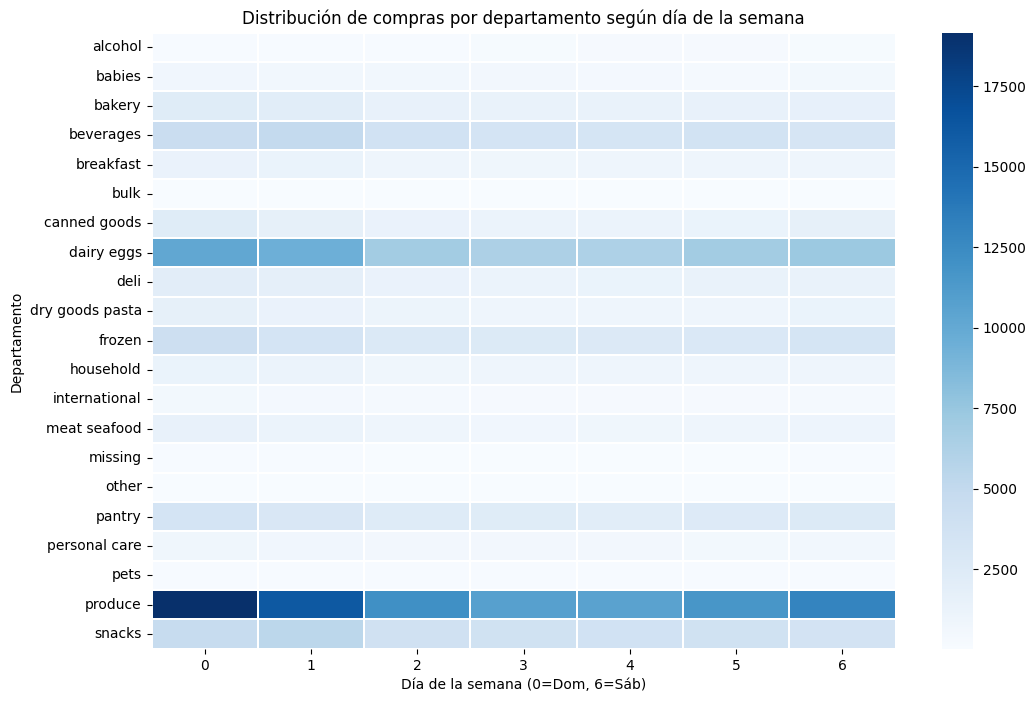

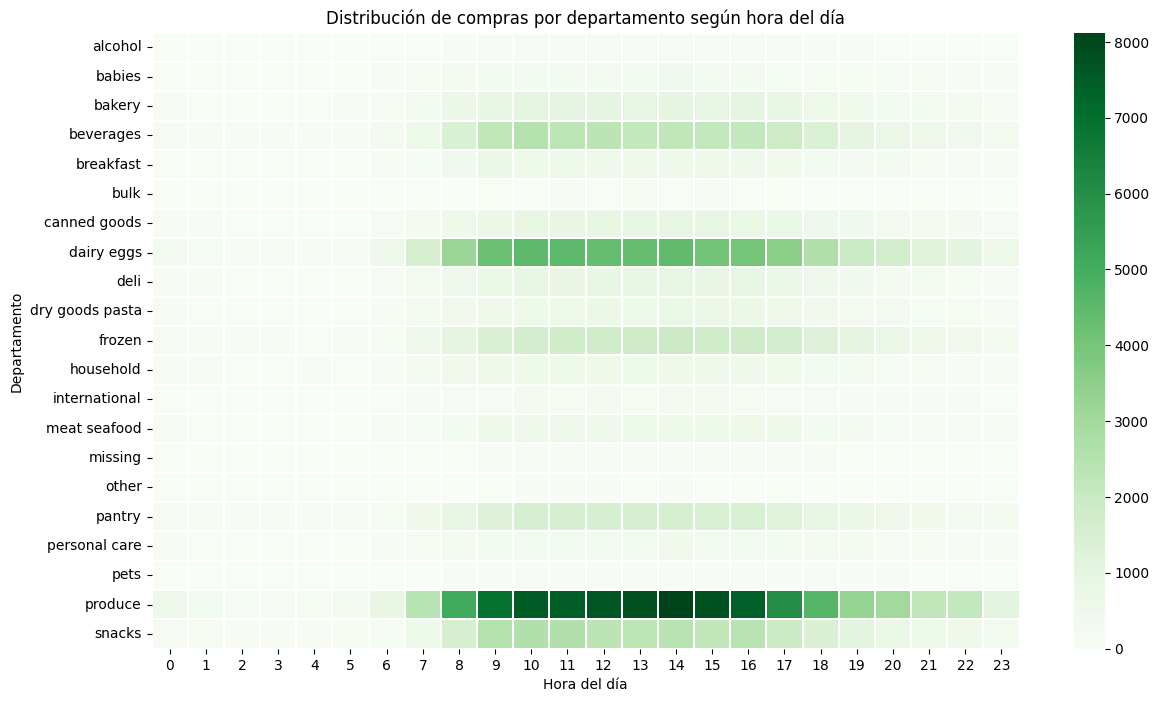

In [33]:
# 1. Unir pedidos con productos y departamentos
df_merged = (
    order_products_prior
    .merge(orders[["order_id", "order_dow", "order_hour_of_day"]], on="order_id")
    .merge(products[["product_id","department_id"]], on="product_id")
    .merge(departments, on="department_id")
)

# 2. Agregar: cuántos productos de cada departamento se compran por día/hora
compras_por_dia = (
    df_merged.groupby(["order_dow", "department"])["product_id"]
    .count()
    .reset_index(name="num_productos")
)

compras_por_hora = (
    df_merged.groupby(["order_hour_of_day", "department"])["product_id"]
    .count()
    .reset_index(name="num_productos")
)

# 3. Pivotear para heatmap
pivot_dia = compras_por_dia.pivot(index="department", columns="order_dow", values="num_productos").fillna(0)
pivot_hora = compras_por_hora.pivot(index="department", columns="order_hour_of_day", values="num_productos").fillna(0)

# 4. Heatmaps
plt.figure(figsize=(12,8))
sns.heatmap(pivot_dia, cmap="Blues", linewidths=0.3)
plt.title("Distribución de compras por departamento según día de la semana")
plt.xlabel("Día de la semana (0=Dom, 6=Sáb)")
plt.ylabel("Departamento")
plt.show()

plt.figure(figsize=(14,8))
sns.heatmap(pivot_hora, cmap="Greens", linewidths=0.3)
plt.title("Distribución de compras por departamento según hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Departamento")
plt.show()

In [35]:
# 1. Filtrar departamentos objetivo
departamentos_objetivo = ["dairy eggs", "produce"]

# 2. Unir productos con departamentos
productos_con_departamentos = products.merge(departments, on="department_id")

# 3. Filtrar solo los departamentos de interés
productos_filtrados = productos_con_departamentos[productos_con_departamentos["department"].isin(departamentos_objetivo)]

# 4. Unir con órdenes para filtrar horario
df_horas = (
    order_products_prior
    .merge(orders[["order_id", "order_hour_of_day"]], on="order_id")
    .merge(productos_filtrados[["product_id", "product_name", "department"]], on="product_id")
)

# 5. Filtrar solo pedidos entre 7 y 20 horas
df_horas_filtrado = df_horas[(df_horas["order_hour_of_day"] >= 7) & (df_horas["order_hour_of_day"] <= 20)]

# 6. Contar ventas por producto
ventas_por_producto = (
    df_horas_filtrado.groupby(["product_id", "product_name", "department"])["order_id"]
    .count()
    .reset_index(name="ventas_7a20")
    .sort_values("ventas_7a20", ascending=False)
)

# 7. Mostrar top 20
ventas_por_producto.head(20)

,product_id,product_name,department,ventas_7a20
1733,24852,Banana,produce,4408
929,13176,Bag of Organic Bananas,produce,3526
1487,21137,Organic Strawberries,produce,2384
1536,21903,Organic Baby Spinach,produce,2169
3291,47209,Organic Hass Avocado,produce,1929
3331,47766,Organic Avocado,produce,1528
3320,47626,Large Lemon,produce,1343
1188,16797,Strawberries,produce,1306
1830,26209,Limes,produce,1277
1961,27966,Organic Raspberries,produce,1212


In [36]:
# 1. Crear tablas separadas por departamento
ventas_produce = ventas_por_producto[ventas_por_producto["department"] == "produce"].reset_index(drop=True)
ventas_dairy_eggs = ventas_por_producto[ventas_por_producto["department"] == "dairy eggs"].reset_index(drop=True)

# 2. Mostrar top 10 de cada tabla
print("=== 🥦 Productos más vendidos en PRODUCE (07-20h) ===")
display(ventas_produce.head(10))

print("=== 🥚 Productos más vendidos en DAIRY EGGS (07-20h) ===")
display(ventas_dairy_eggs.head(10))

=== 🥦 Productos más vendidos en PRODUCE (07-20h) ===


,product_id,product_name,department,ventas_7a20
0,24852,Banana,produce,4408
1,13176,Bag of Organic Bananas,produce,3526
2,21137,Organic Strawberries,produce,2384
3,21903,Organic Baby Spinach,produce,2169
4,47209,Organic Hass Avocado,produce,1929
5,47766,Organic Avocado,produce,1528
6,47626,Large Lemon,produce,1343
7,16797,Strawberries,produce,1306
8,26209,Limes,produce,1277
9,27966,Organic Raspberries,produce,1212


=== 🥚 Productos más vendidos en DAIRY EGGS (07-20h) ===


,product_id,product_name,department,ventas_7a20
0,27845,Organic Whole Milk,dairy eggs,1197
1,49235,Organic Half & Half,dairy eggs,712
2,27086,Half & Half,dairy eggs,627
3,22035,Organic Whole String Cheese,dairy eggs,527
4,35951,Organic Unsweetened Almond Milk,dairy eggs,518
5,24838,Unsweetened Almondmilk,dairy eggs,451
6,5785,Organic Reduced Fat 2% Milk,dairy eggs,445
7,33731,Grated Parmesan,dairy eggs,413
8,18465,Organic Grade A Free Range Large Brown Eggs,dairy eggs,365
9,47144,Unsweetened Original Almond Breeze Almond Milk,dairy eggs,362


In [38]:
# 1. Unir pedidos con productos y departamentos
df_merged = (
    order_products_prior
    .merge(orders[["order_id", "order_dow"]], on="order_id")
    .merge(products[["product_id","department_id"]], on="product_id")
    .merge(departments, on="department_id")
)

# 2. Filtrar departamento produce y día domingo (0)
ventas_produce_domingo = df_merged[
    (df_merged["department"] == "produce") & (df_merged["order_dow"] == 0)
]

# 3. Total de ventas
total_ventas_produce_domingo = ventas_produce_domingo.shape[0]

print(f"Total de ventas del departamento 'produce' el domingo: {total_ventas_produce_domingo:,}")


Total de ventas del departamento 'produce' el domingo: 19,162


================================================================================

Modelo de Machine Learning
¿Cómo predecir qué producto un cliente probablemente volverá a comprar en su próximo pedido? (para recomendación personalizada o cross-selling).

In [41]:
# 1. Construir dataset (ejemplo simplificado)
# Unir historial de usuario-producto con reorders
user_product = (
    order_products_prior
    .merge(orders[["order_id","user_id","order_number","days_since_prior_order"]], on="order_id")
    .merge(products[["product_id","department_id"]], on="product_id")
)

# Features: recency, frecuencia, popularidad del producto
features = (
    user_product.groupby(["user_id","product_id"])
    .agg(
        n_compras=("order_id","count"),
        n_reorders=("reordered","sum"),
        ultima_compra=("order_number","max"),
        recency=("order_number","max"),
    )
    .reset_index()
)

# Target: ¿fue reordenado en el último pedido (train)?
# Merge order_products_train with orders to get user_id
labels = order_products_train.merge(orders[["order_id", "user_id"]], on="order_id").groupby(["user_id","product_id"])["reordered"].max().reset_index()


# Dataset final
dataset = features.merge(labels, on=["user_id","product_id"], how="left").fillna(0)

# Drop non-numeric columns before splitting
X = dataset.drop(columns=["reordered", "user_id", "product_id"])
y = dataset["reordered"]

# 2. Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Modelo
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 4. Evaluación
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     53062
         1.0       0.49      0.00      0.01      5301

    accuracy                           0.91     58363
   macro avg       0.70      0.50      0.48     58363
weighted avg       0.87      0.91      0.87     58363

ROC-AUC: 0.6567305141278638


In [43]:
# ========================
# 1. Popularidad del producto (global)
# ========================
pop_producto = (
    order_products_prior.groupby("product_id")
    .agg(
        popularidad_producto=("order_id","count"),
        ratio_reorder_producto=("reordered","mean")
    )
    .reset_index()
)

# ========================
# 2. Métricas de usuario
# ========================
# total pedidos por usuario
pedidos_usuario = orders.groupby("user_id")["order_id"].count().reset_index(name="total_pedidos_usuario")

# tamaño promedio carrito
tamano_carrito = (
    order_products_prior.groupby("order_id")["product_id"].count().reset_index(name="tamano_carrito")
    .merge(orders[["order_id","user_id"]], on="order_id")
    .groupby("user_id")["tamano_carrito"].mean().reset_index(name="tamano_promedio_carrito")
)

# frecuencia promedio días entre pedidos
frecuencia_dias = orders.groupby("user_id")["days_since_prior_order"].mean().reset_index(name="frecuencia_promedio_dias")

# merge de métricas de usuario
usuario_stats = pedidos_usuario.merge(tamano_carrito, on="user_id").merge(frecuencia_dias, on="user_id")

# ========================
# 3. User-Product stats
# ========================
user_product = (
    order_products_prior
    .merge(orders[["order_id","user_id","order_number","days_since_prior_order"]], on="order_id")
)

features = (
    user_product.groupby(["user_id","product_id"])
    .agg(
        n_compras=("order_id","count"),
        n_reorders=("reordered","sum"),
        ultima_compra=("order_number","max"),
        recency=("order_number","max"),
    )
    .reset_index()
)

features["ratio_reorders"] = features["n_reorders"] / features["n_compras"]

# ========================
# 4. Target
# ========================
labels = (
    order_products_train
    .merge(orders[["order_id","user_id"]], on="order_id")
    .groupby(["user_id","product_id"])["reordered"]
    .max()
    .reset_index()
)

# ========================
# 5. Dataset final
# ========================
dataset = (
    features
    .merge(pop_producto, on="product_id", how="left")
    .merge(usuario_stats, on="user_id", how="left")
    .merge(labels, on=["user_id","product_id"], how="left")
    .fillna(0)
)

# ========================
# 6. Preparar X y y
# ========================
X = dataset.drop(columns=["reordered","user_id","product_id"])
y = dataset["reordered"]

# ========================
# 7. Train/test split
# ========================

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========================
# 8. Modelo con class_weight balanced
# ========================
model = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1, class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     53062
         1.0       0.52      0.04      0.07      5301

    accuracy                           0.91     58363
   macro avg       0.72      0.52      0.51     58363
weighted avg       0.88      0.91      0.87     58363

ROC-AUC: 0.7430091958856527
